Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."
Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


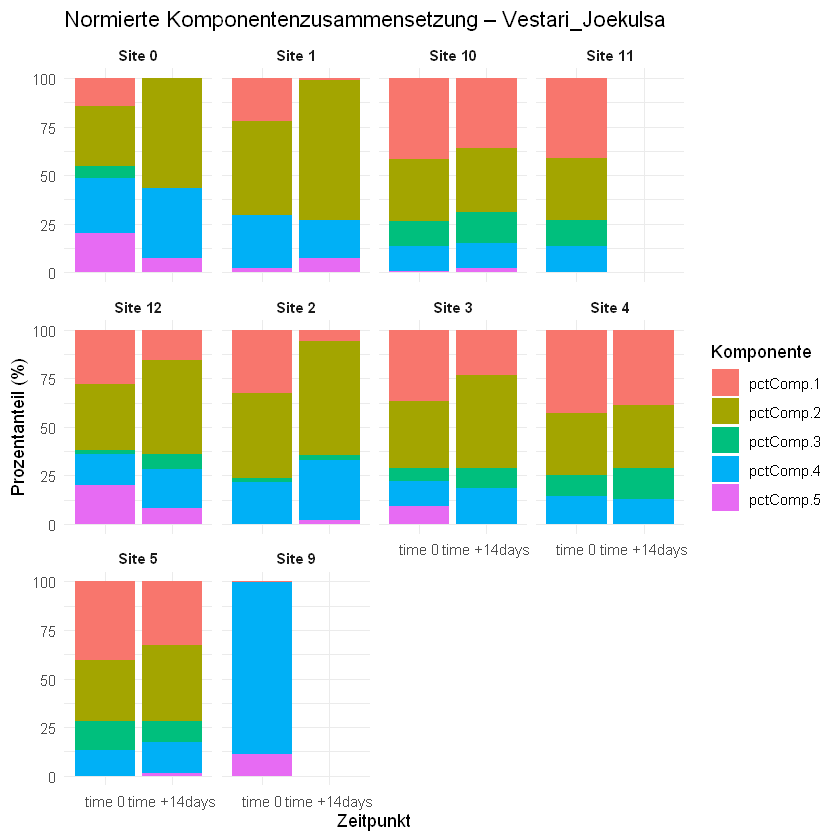

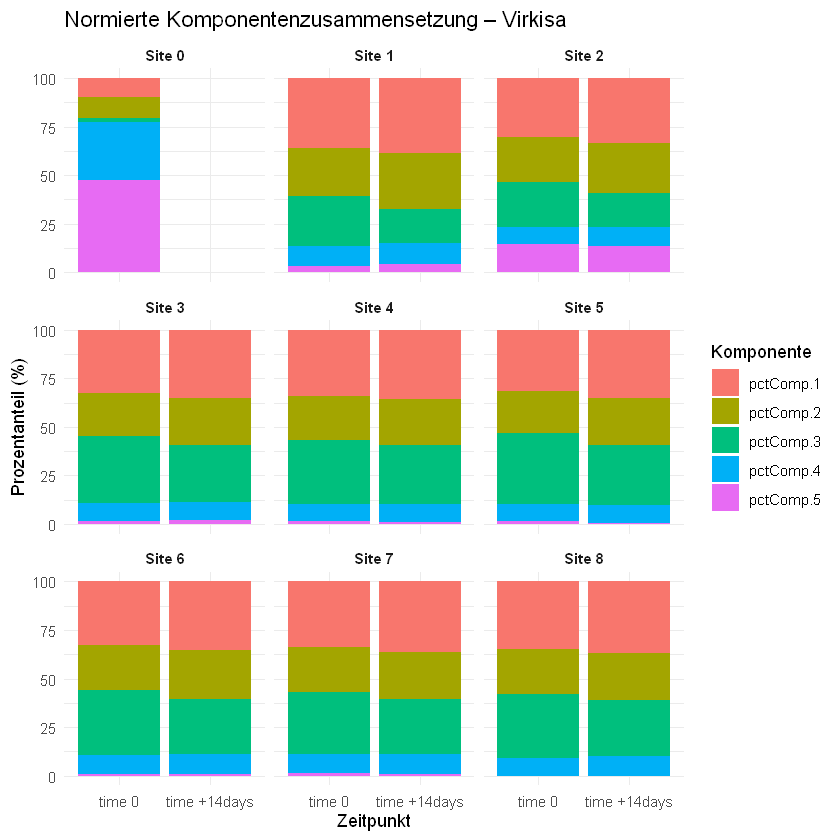

In [6]:
# ohne missing zeilen 

# Pakete laden
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# Datei einlesen
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path)

# Neue Spaltenstruktur: Komponenten mit Zeitangabe in "long format"
df_long <- df %>%
  # Standortinfos beibehalten
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  # Zeit 0
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # Zeit +14 Tage
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(Time = factor(Time, levels = c("time 0", "time +14days")),
         Component = factor(Component, levels = paste0("pctComp.", 1:5)),
         SiteLabel = paste("Site", site_nr))

# Jetzt: Mittelwert je Komponente & Normierung auf 100%
df_normalized <- df_long %>%
  group_by(river_name, site_nr, SiteLabel, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, SiteLabel, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%  # 👉 normiert auf 100%
  ungroup()

# Plot pro Fluss
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = Component)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    labs(title = paste("Normierte Komponentenzusammensetzung –", river),
         x = "Zeitpunkt", y = "Prozentanteil (%)",
         fill = "Komponente") +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."


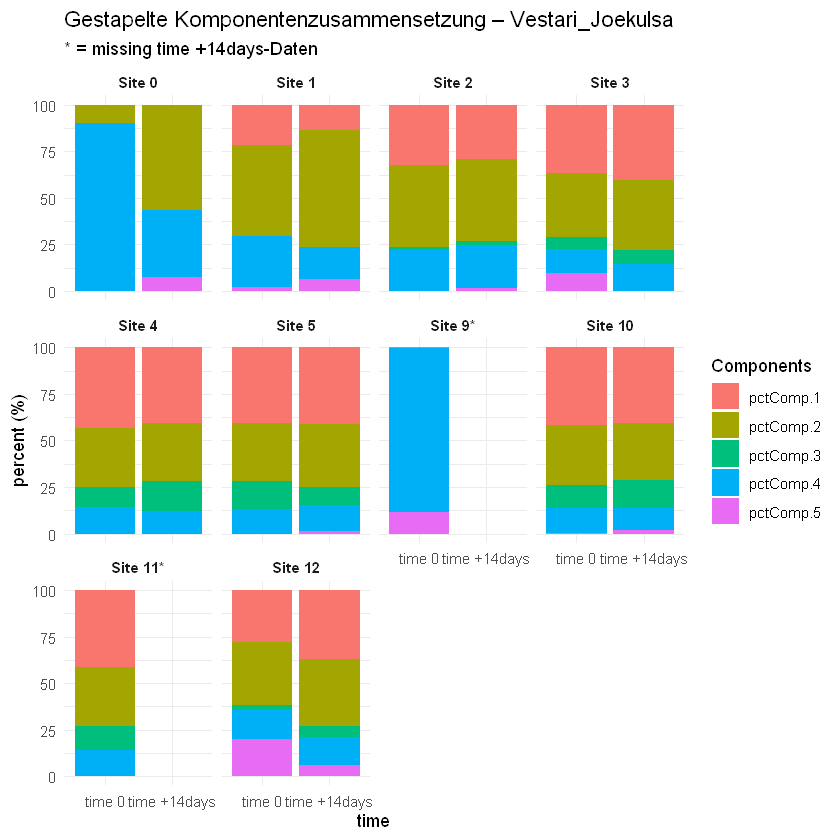

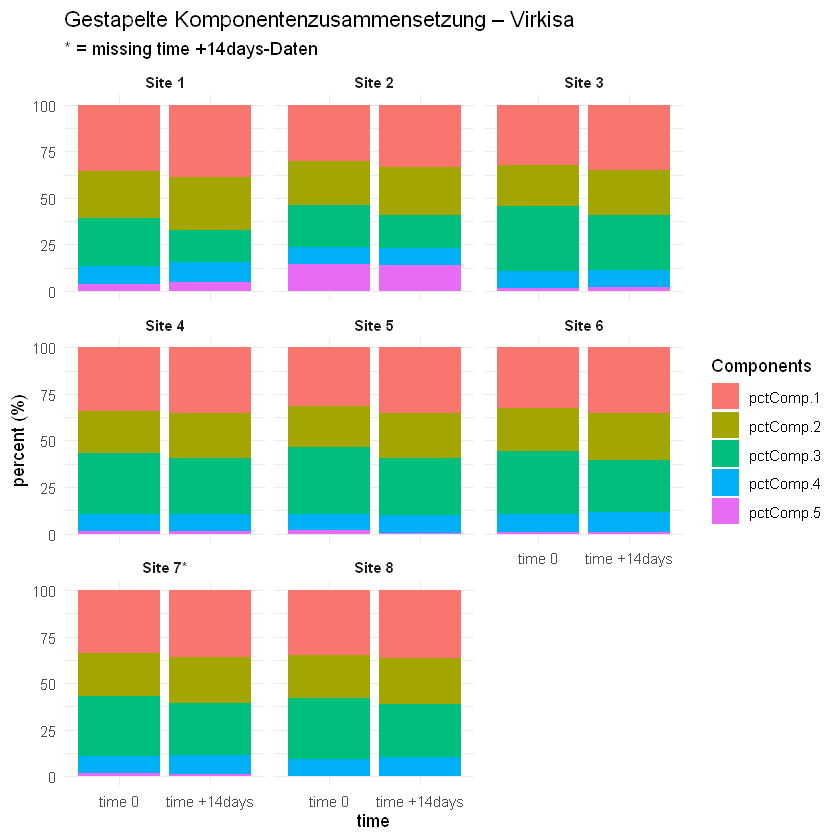

In [14]:
# mit missing zeilen 


# Pakete laden
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Excel-Datei einlesen
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path, sheet = "FINAL_final_final_update")

# 2. Fehlerhafte Sites identifizieren (wenn sum of time+14days ≠ 100%)
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3. Daten in Long-Format umwandeln
df_long <- df %>%
  # time 0
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # time +14days
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4. Mittelwerte pro Standort + Zeit berechnen & auf 100 % normieren
df_normalized <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5. Problematische Sites mit * markieren
df_normalized <- df_normalized %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in%
                   paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel = ifelse(is_problem,
                       paste0("Site ", site_nr, "*"),
                       paste0("Site ", site_nr))
  )

# 6. SiteLabel nach numerischer Reihenfolge sortieren
site_order <- df_normalized %>%
  distinct(site_nr, SiteLabel) %>%
  arrange(site_nr) %>%
  pull(SiteLabel)

df_normalized$SiteLabel <- factor(df_normalized$SiteLabel, levels = site_order)

# 7. Plot pro Fluss
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = Component)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    labs(
      title = paste("Gestapelte Komponentenzusammensetzung –", river),
      subtitle = "* = missing time +14days-Daten",
      x = "time", y = "percent (%)",
      fill = "Components"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


In [10]:
#Speichern 


# Ordnerpfad festlegen
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"

# Für jeden Fluss speichern wir einen Plot als PNG
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = Component)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    labs(
      title = paste("Gestapelte Komponentenzusammensetzung –", river),
      subtitle = "* = unvollständige time +14days-Daten",
      x = "Zeitpunkt", y = "Prozentanteil (%)",
      fill = "Komponente"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  # Dateiname zusammensetzen (z. B. "Vestari_Joekulsa_Saeulen.png")
  filename <- paste0(output_dir, "/", river, "_Saeulen.png")

  # Plot speichern
  ggsave(filename, plot = p, width = 12, height = 6, dpi = 300)
}


Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."
Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


✅ Funktionen enthält:

    Liest deine Excel-Datei ein,

    Berechnet Mittelwerte pro Standort und Zeit,

    Markiert problematische time +14days-Daten mit *, Normiert auf 100 % (wenn nötig)

    Sortiert die Sites korrekt numerisch,

    Vergibt sprechende Namen an die Komponenten (Humic-like etc.),

    Färbt die Komponenten sinnvoll ein (Braun, Grün, Blau, Grau etc.),

    Erstellt saubere gestapelte Säulenplots pro Fluss.

Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."


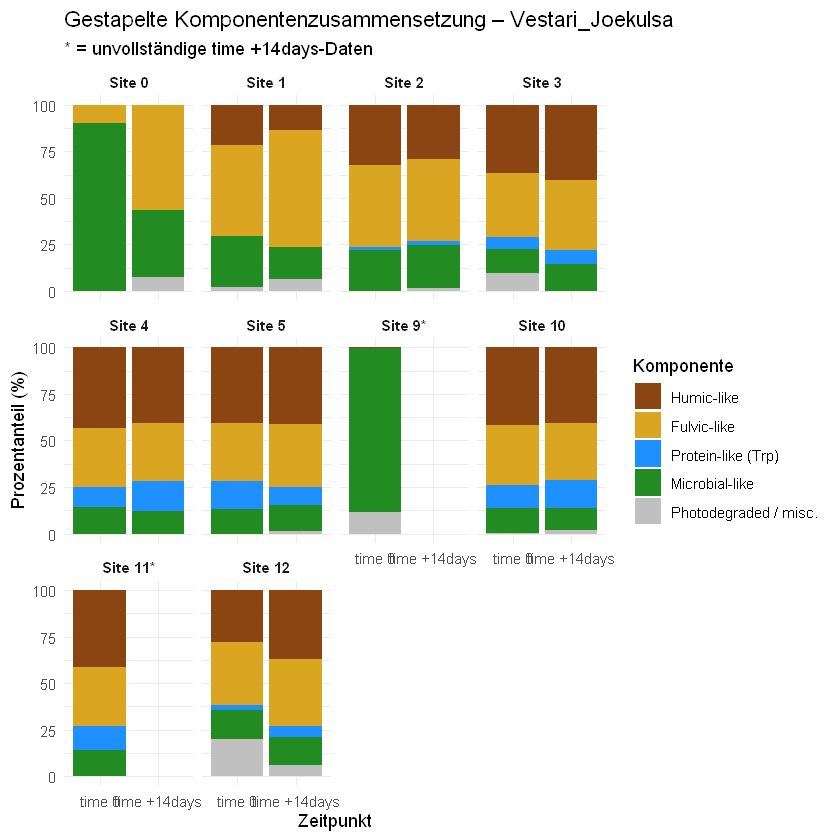

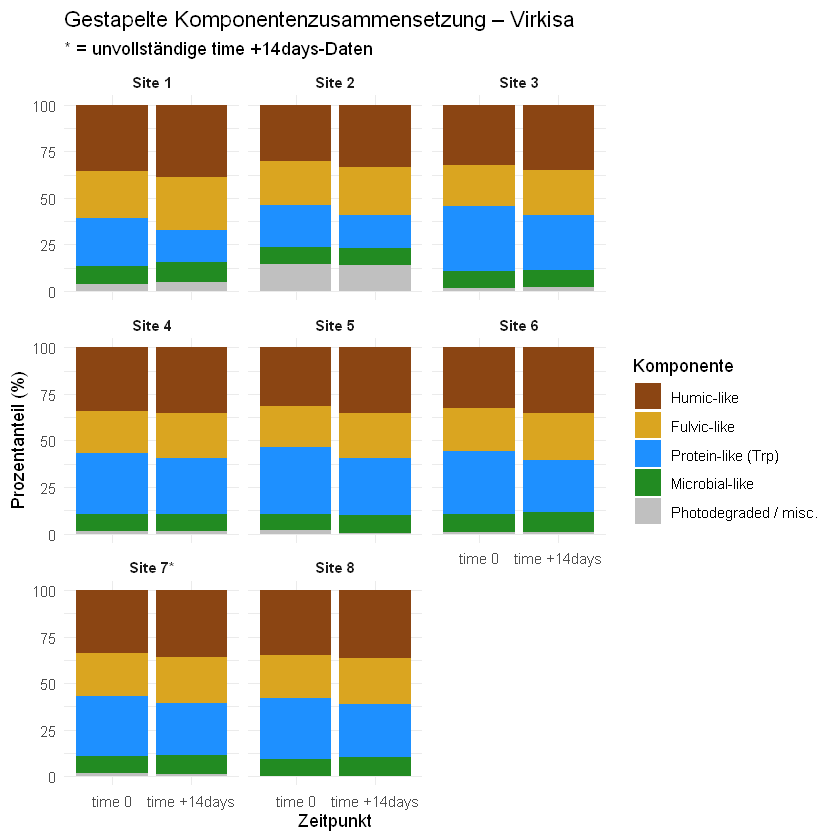

In [16]:
# Pakete laden
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Excel-Datei einlesen
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path)

# 2. Fehlerhafte Sites identifizieren (wenn sum of time+14days ≠ 100%)
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3. Daten in Long-Format umwandeln
df_long <- df %>%
  # time 0
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # time +14days
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4. Mittelwerte pro Standort + Zeit berechnen & auf 100 % normieren
df_normalized <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5. Problematische Sites mit * markieren
df_normalized <- df_normalized %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in%
                   paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel = ifelse(is_problem,
                       paste0("Site ", site_nr, "*"),
                       paste0("Site ", site_nr))
  )

# 6. Sites numerisch sortieren
site_order <- df_normalized %>%
  distinct(site_nr, SiteLabel) %>%
  arrange(site_nr) %>%
  pull(SiteLabel)

df_normalized$SiteLabel <- factor(df_normalized$SiteLabel, levels = site_order)

# 7. Sprechende Namen und sinnvolle Farben für Komponenten
component_labels <- c(
  "pctComp.1" = "Humic-like",
  "pctComp.2" = "Fulvic-like",
  "pctComp.3" = "Protein-like (Trp)",
  "pctComp.4" = "Microbial-like",
  "pctComp.5" = "Photodegraded / misc."
)

# Neue, stärker differenzierte Farben
component_colors <- c(
  "Humic-like"            = "#8B4513",  # Dunkelbraun
  "Fulvic-like"           = "#DAA520",  # Goldgelb
  "Protein-like (Trp)"    = "#1E90FF",  # Blau
  "Microbial-like"        = "#228B22",  # Grün
  "Photodegraded / misc." = "#C0C0C0"   # Hellgrau
)




# Labels übernehmen
df_normalized$ComponentLabel <- component_labels[as.character(df_normalized$Component)]
df_normalized$ComponentLabel <- factor(df_normalized$ComponentLabel,
                                       levels = component_labels)

# 8. Plot pro Fluss (mit Farben und Labels)
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Gestapelte Komponentenzusammensetzung –", river),
      subtitle = "* = unvollständige time +14days-Daten",
      x = "Zeitpunkt", y = "Prozentanteil (%)",
      fill = "Komponente"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


In [18]:
# Ordnerpfad festlegen
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"

# Für jeden Fluss speichern wir den farblich gelabelten Plot als PNG
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Gestapelte Komponentenzusammensetzung –", river),
      subtitle = "* = unvollständige time +14days-Daten",
      x = "Zeitpunkt", y = "Prozentanteil (%)",
      fill = "Komponente"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  # Dateiname zusammensetzen
  filename <- paste0(output_dir, "/", river, "_Komponentenplot.png")

  # Plot speichern (12x6 Zoll, 300 dpi)
  ggsave(filename, plot = p, width = 12, height = 6, dpi = 300)
}


Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_bar()`)."
